<a href="https://colab.research.google.com/github/manojmanivannan/ApacheSparkEssentials/blob/master/ML_2_SparkByPluralsight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Environment

In [1]:
!apt-get update
!apt-get install -y openjdk-8-jdk-headless scala jq  > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
!pip install -q pyspark findspark
!wget https://github.com/tanaikech/goodls/releases/download/v2.0.1/goodls_linux_amd64
!chmod +x goodls_linux_amd64

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.co

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [3]:
!python --version

Python 3.8.16


In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

# Spark session & context
conf = SparkConf().set('spark.ui.port', '4050')
try:
  sc = SparkContext(conf=conf)
except ValueError:
  sc.stop()
  sc = SparkContext(conf=conf)

spark = SparkSession.builder.master('local[2]').getOrCreate()

In [5]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [6]:
# create new token from ngrok
get_ipython().system_raw('./ngrok authtoken 2Idd4iDgYUbNZKlYdaGtpmtQ9WR_4wv1M8BfnJmQKXc9gvfjC')
# revoke the token once you close the notebook
get_ipython().system_raw('./ngrok http 4050 &')

In [7]:
!sleep 10 && curl -s http://localhost:4040/api/tunnels | python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.8/json/__init__.py", line 293, in load
    return loads(fp.read(),
  File "/usr/lib/python3.8/json/__init__.py", line 357, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.8/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.8/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [8]:
!./goodls_linux_amd64 -u https://drive.google.com/file/d/1C9Ks9dXGfLkM2rj9ULjtMb2_Qx3dAT9f/view?usp=share_link

{"Filename": "titanic.csv", "Type": "file", "MimeType": "text/csv", "FileSize": 61194}


In [9]:
rawData = spark.read\
                .format('csv')\
                .option('header','true')\
                .load('titanic.csv')

In [10]:
rawData.toPandas().head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,None,S


In [11]:
from pyspark.sql.functions import col

dataset = rawData.select(col('Survived').cast('float'),
                         col('Pclass').cast('float'),
                         col('Sex'),
                         col('Age').cast('float'),
                         col('Fare').cast('float'),
                         col('Embarked'))

dataset.toPandas().head()

,Survived,Pclass,Sex,Age,Fare,Embarked
0,0.0,3.0,male,22.0,7.250000,S
1,1.0,1.0,female,38.0,71.283302,C
2,1.0,3.0,female,26.0,7.925000,S
3,1.0,1.0,female,35.0,53.099998,S
4,0.0,3.0,male,35.0,8.050000,S


In [12]:
dataset.count()

891

In [13]:
dataset = dataset.replace('?',None).dropna(how='any')
dataset.count()

712

In [14]:
from pyspark.ml.feature import StringIndexer

dataset = StringIndexer(
    inputCol='Sex',
    outputCol='Gender',
    handleInvalid='keep'
).fit(dataset).transform(dataset)

dataset = StringIndexer(
    inputCol='Embarked',
    outputCol='Boarded',
    handleInvalid='keep'
).fit(dataset).transform(dataset)

dataset.toPandas().head()


,Survived,Pclass,Sex,Age,Fare,Embarked,Gender,Boarded
0,0.0,3.0,male,22.0,7.250000,S,0.0,0.0
1,1.0,1.0,female,38.0,71.283302,C,1.0,1.0
2,1.0,3.0,female,26.0,7.925000,S,1.0,0.0
3,1.0,1.0,female,35.0,53.099998,S,1.0,0.0
4,0.0,3.0,male,35.0,8.050000,S,0.0,0.0


In [15]:
dataset = dataset.drop('Sex','Embarked')
dataset.toPandas().head()

,Survived,Pclass,Age,Fare,Gender,Boarded
0,0.0,3.0,22.0,7.250000,0.0,0.0
1,1.0,1.0,38.0,71.283302,1.0,1.0
2,1.0,3.0,26.0,7.925000,1.0,0.0
3,1.0,1.0,35.0,53.099998,1.0,0.0
4,0.0,3.0,35.0,8.050000,0.0,0.0


In [16]:
requiredFeatures = ['Survived', 'Pclass', 'Age', 'Fare', 'Gender', 'Boarded']

In [17]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=requiredFeatures, outputCol='features')

In [18]:
transformed_data = assembler.transform(dataset)

In [19]:
transformed_data.toPandas().head()

,Survived,Pclass,Age,Fare,Gender,Boarded,features
0,0.0,3.0,22.0,7.250000,0.0,0.0,"[0.0, 3.0, 22.0, 7.25, 0.0, 0.0]"
1,1.0,1.0,38.0,71.283302,1.0,1.0,"[1.0, 1.0, 38.0, 71.2833023071289, 1.0, 1.0]"
2,1.0,3.0,26.0,7.925000,1.0,0.0,"[1.0, 3.0, 26.0, 7.925000190734863, 1.0, 0.0]"
3,1.0,1.0,35.0,53.099998,1.0,0.0,"[1.0, 1.0, 35.0, 53.099998474121094, 1.0, 0.0]"
4,0.0,3.0,35.0,8.050000,0.0,0.0,"[0.0, 3.0, 35.0, 8.050000190734863, 0.0, 0.0]"


In [20]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=8, seed=3)
model = kmeans.fit(transformed_data)

In [21]:
clusteredData = model.transform(transformed_data)

In [22]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(clusteredData)
print('Silhouette with squared euclidean distance = ',silhouette)

Silhouette with squared euclidean distance =  0.6314387412353603


In [23]:
centers = model.clusterCenters()
print('Cluster centers:')
for center in centers:
  print(center)

Cluster centers:
[ 0.23913043  2.17391304 51.47282609 16.22164997  0.20652174  0.20652174]
[ 0.26557377  2.76065574 25.32459016  9.60222564  0.27213115  0.21967213]
[1.00000000e+00 1.00000000e+00 3.53333333e+01 5.12329224e+02
 3.33333333e-01 1.00000000e+00]
[  0.73333333   1.          30.33333333 239.99193726   0.73333333
   0.53333333]
[  0.73333333   1.          32.43066667 131.18388341   0.63333333
   0.5       ]
[ 0.68888889  1.16666667 36.03333333 69.30111321  0.48888889  0.38888889]
[ 0.53658537  2.63414634  7.28353659 26.93688921  0.48780488  0.23170732]
[ 0.45263158  1.93684211 34.43684211 28.13162209  0.44210526  0.21052632]


In [24]:
clusteredData.toPandas().head()

,Survived,Pclass,Age,Fare,Gender,Boarded,features,prediction
0,0.0,3.0,22.0,7.250000,0.0,0.0,"[0.0, 3.0, 22.0, 7.25, 0.0, 0.0]",1
1,1.0,1.0,38.0,71.283302,1.0,1.0,"[1.0, 1.0, 38.0, 71.2833023071289, 1.0, 1.0]",5
2,1.0,3.0,26.0,7.925000,1.0,0.0,"[1.0, 3.0, 26.0, 7.925000190734863, 1.0, 0.0]",1
3,1.0,1.0,35.0,53.099998,1.0,0.0,"[1.0, 1.0, 35.0, 53.099998474121094, 1.0, 0.0]",5
4,0.0,3.0,35.0,8.050000,0.0,0.0,"[0.0, 3.0, 35.0, 8.050000190734863, 0.0, 0.0]",1


In [25]:
from pyspark.sql.functions import *

dataset.select(avg('Survived'),
               avg('Pclass'),
               avg('Age'),
               avg('Fare'),
               avg('Gender'),
               avg('Boarded')).toPandas()

,avg(Survived),avg(Pclass),avg(Age),avg(Fare),avg(Gender),avg(Boarded)
0,0.404494,2.240169,29.642093,34.567251,0.363764,0.261236


In [26]:
clusteredData.groupBy('prediction').agg(
                                      avg('Survived'),
                                      avg('Pclass'),
                                      avg('Age'),
                                      avg('Fare'),
                                      avg('Gender'),
                                      avg('Boarded'),
                                      count('prediction')
                                    ).orderBy('prediction').toPandas()

,prediction,avg(Survived),avg(Pclass),avg(Age),avg(Fare),avg(Gender),avg(Boarded),count(prediction)
0,0,0.239130,2.173913,51.472826,16.221650,0.206522,0.206522,92
1,1,0.265574,2.760656,25.324590,9.602226,0.272131,0.219672,305
2,2,1.000000,1.000000,35.333333,512.329224,0.333333,1.000000,3
3,3,0.733333,1.000000,30.333333,239.991937,0.733333,0.533333,15
4,4,0.733333,1.000000,32.430667,131.183883,0.633333,0.500000,30
5,5,0.688889,1.166667,36.033333,69.301113,0.488889,0.388889,90
6,6,0.536585,2.634146,7.283537,26.936889,0.487805,0.231707,82
7,7,0.452632,1.936842,34.436842,28.131622,0.442105,0.210526,95


In [27]:
clusteredData.filter(clusteredData.prediction ==5).toPandas()

,Survived,Pclass,Age,Fare,Gender,Boarded,features,prediction
0,1.0,1.0,38.0,71.283302,1.0,1.0,"[1.0, 1.0, 38.0, 71.2833023071289, 1.0, 1.0]",5
1,1.0,1.0,35.0,53.099998,1.0,0.0,"[1.0, 1.0, 35.0, 53.099998474121094, 1.0, 0.0]",5
2,0.0,1.0,54.0,51.862499,0.0,0.0,"[0.0, 1.0, 54.0, 51.86249923706055, 0.0, 0.0]",5
3,0.0,1.0,28.0,82.170799,0.0,1.0,"[0.0, 1.0, 28.0, 82.1707992553711, 0.0, 1.0]",5
4,0.0,1.0,42.0,52.000000,0.0,0.0,"[0.0, 1.0, 42.0, 52.0, 0.0, 0.0]",5
...,...,...,...,...,...,...,...,...
85,1.0,1.0,39.0,83.158302,1.0,1.0,"[1.0, 1.0, 39.0, 83.1583023071289, 1.0, 1.0]",5
86,1.0,3.0,32.0,56.495800,0.0,0.0,"[1.0, 3.0, 32.0, 56.49580001831055, 0.0, 0.0]",5
87,0.0,1.0,31.0,50.495800,0.0,0.0,"[0.0, 1.0, 31.0, 50.49580001831055, 0.0, 0.0]",5
88,1.0,1.0,47.0,52.554199,1.0,0.0,"[1.0, 1.0, 47.0, 52.55419921875, 1.0, 0.0]",5


# Principle Component Analysis

In [28]:
!./goodls_linux_amd64 -u https://drive.google.com/file/d/1gfjrU46j9_068cVreEQz_8cA6YvpOhz8/view?usp=share_link

{"Filename": "day.csv", "Type": "file", "MimeType": "text/csv", "FileSize": 57569}


In [29]:
rawData = spark.read\
                .format('csv')\
                .option('header','true')\
                .load('day.csv')

In [30]:
rawData.toPandas().head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.2,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.22927,0.436957,0.1869,82,1518,1600


In [31]:
from pyspark.sql.functions import col

dataset = rawData.select(
              col('season').cast('float'),
              col('yr').cast('float'),
              col('mnth').cast('float'),
              col('holiday').cast('float'),
              col('weekday').cast('float'),
              col('workingday').cast('float'),
              col('weathersit').cast('float'),
              col('temp').cast('float'),
              col('atemp').cast('float'),
              col('hum').cast('float'),
              col('windspeed').cast('float'),
              col('cnt').cast('float')
            )

dataset.toPandas().head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1.0,0.0,1.0,0.0,6.0,0.0,2.0,0.344167,0.363625,0.805833,0.160446,985.0
1,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.363478,0.353739,0.696087,0.248539,801.0
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.196364,0.189405,0.437273,0.248309,1349.0
3,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.200000,0.212122,0.590435,0.160296,1562.0
4,1.0,0.0,1.0,0.0,3.0,1.0,1.0,0.226957,0.229270,0.436957,0.186900,1600.0


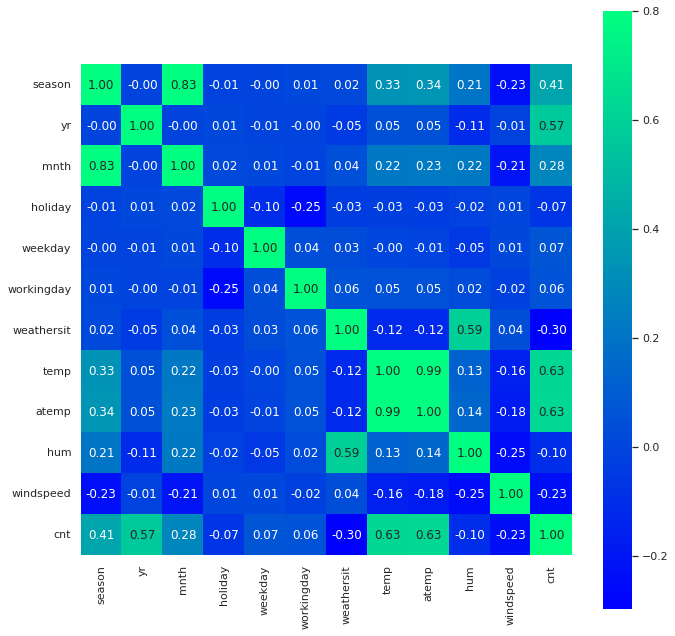

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

corrmat = dataset.toPandas().corr()
plt.figure(figsize=(11,11))
sns.set(font_scale=1.0)
sns.heatmap(corrmat,vmax=0.8,square=True,annot=True,fmt='.2f',cmap='winter')
plt.show()

In [33]:
featureCols = dataset.columns.copy()
featureCols.remove('cnt')

featureCols

['season',
 'yr',
 'mnth',
 'holiday',
 'weekday',
 'workingday',
 'weathersit',
 'temp',
 'atemp',
 'hum',
 'windspeed']

In [34]:
featureCols.__len__()

11

In [35]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=featureCols,
                            outputCol='features')

In [36]:
vectorDF = assembler.transform(dataset)
vectorDF.toPandas().head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,features
0,1.0,0.0,1.0,0.0,6.0,0.0,2.0,0.344167,0.363625,0.805833,0.160446,985.0,"[1.0, 0.0, 1.0, 0.0, 6.0, 0.0, 2.0, 0.34416699..."
1,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.363478,0.353739,0.696087,0.248539,801.0,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.36347800..."
2,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.196364,0.189405,0.437273,0.248309,1349.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.19636400..."
3,1.0,0.0,1.0,0.0,2.0,1.0,1.0,0.200000,0.212122,0.590435,0.160296,1562.0,"[1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.20000000..."
4,1.0,0.0,1.0,0.0,3.0,1.0,1.0,0.226957,0.229270,0.436957,0.186900,1600.0,"[1.0, 0.0, 1.0, 0.0, 3.0, 1.0, 1.0, 0.22695699..."


In [37]:
(trainingData, testData) = vectorDF.randomSplit([0.8,0.2])

In [38]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(maxIter=100,
                      regParam=1.0,
                      elasticNetParam=0.8,
                      labelCol='cnt',
                      featuresCol='features')

In [39]:
model = lr.fit(trainingData)

In [40]:
print('Training R^2 score = ', model.summary.r2)
print('Training RMSE = ', model.summary.rootMeanSquaredError)

Training R^2 score =  0.7971599218941435
Training RMSE =  878.7000710610023


In [41]:
predictions = model.transform(testData)
predictions.toPandas().head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,features,prediction
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.138333,0.116175,0.434167,0.361950,822.0,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.13833299...",667.108929
1,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.196364,0.189405,0.437273,0.248309,1349.0,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.19636400...",1508.007987
2,1.0,0.0,1.0,0.0,3.0,1.0,3.0,0.217500,0.203600,0.862500,0.293850,506.0,"[1.0, 0.0, 1.0, 0.0, 3.0, 1.0, 3.0, 0.21750000...",-96.478685
3,1.0,0.0,1.0,0.0,4.0,1.0,1.0,0.195000,0.219700,0.687500,0.113837,431.0,"[1.0, 0.0, 1.0, 0.0, 4.0, 1.0, 1.0, 0.19499999...",1927.570939
4,1.0,0.0,1.0,0.0,5.0,1.0,1.0,0.177500,0.157833,0.457083,0.353242,1543.0,"[1.0, 0.0, 1.0, 0.0, 5.0, 1.0, 1.0, 0.17749999...",1342.079994


In [42]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    labelCol='cnt',
    predictionCol='prediction',
    metricName='r2'
)
rsquare = evaluator.evaluate(predictions)
print("Test R2 score = %g" % rsquare)

evaluator = RegressionEvaluator(
    labelCol='cnt',
    predictionCol='prediction',
    metricName='rmse'
)
rmse = evaluator.evaluate(predictions)
print("Test RMSE score = %g" % rmse)

Test R2 score = 0.809377
Test RMSE score = 815.76


In [43]:
predictionsPandas = predictions.toPandas()

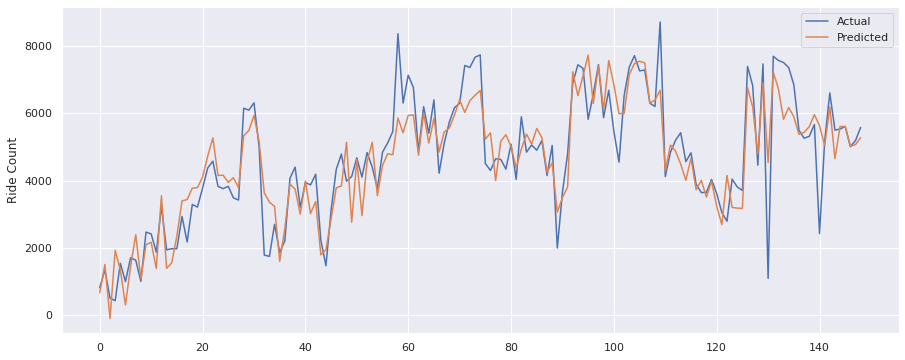

In [44]:
plt.figure(figsize=(15,6))

plt.plot(predictionsPandas['cnt'],label='Actual')
plt.plot(predictionsPandas['prediction'], label='Predicted')
plt.ylabel('Ride Count')
plt.legend()

plt.show()

In [45]:
from pyspark.ml.feature import PCA

pca = PCA(k=8,
          inputCol='features',
          outputCol='pcaFeatures')

In [46]:
pcaTransformed = pca.fit(vectorDF)

In [47]:
pcaFeatureData = pcaTransformed.transform(vectorDF).select('pcaFeatures')
pcaFeatureData.toPandas().head()

,pcaFeatures
0,"[-1.2994341051211546, -6.000295788252946, 0.38..."
1,"[-1.2560740466051443, -0.0018090609273901468, ..."
2,"[-1.2498374389125806, -1.0026992468169056, 0.5..."
3,"[-1.2589193782131007, -2.0018604800043334, 0.5..."
4,"[-1.264951594573436, -3.0022673722336357, 0.58..."


In [48]:
pcaTransformed.explainedVariance

DenseVector([0.7093, 0.2227, 0.0201, 0.0171, 0.0137, 0.0119, 0.0028, 0.0014])

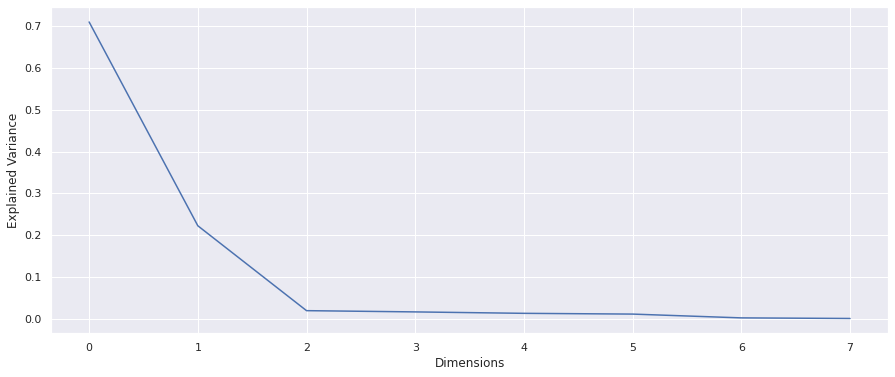

In [49]:
plt.figure(figsize=(15,6))

plt.plot(pcaTransformed.explainedVariance)
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance')
plt.show()

In [50]:
from pyspark.sql.functions import monotonically_increasing_id

pcaFeatureData = pcaFeatureData.withColumn('row_index',monotonically_increasing_id())
vectorDF = vectorDF.withColumn('row_index', monotonically_increasing_id())

In [51]:
transformedData = pcaFeatureData.join(vectorDF, on=['row_index'])\
                                .sort('row_index')\
                                .select('cnt','pcaFeatures')

transformedData.toPandas().head()                                

,cnt,pcaFeatures
0,985.0,"[-1.2994341051211546, -6.000295788252946, 0.38..."
1,801.0,"[-1.2560740466051443, -0.0018090609273901468, ..."
2,1349.0,"[-1.2498374389125806, -1.0026992468169056, 0.5..."
3,1562.0,"[-1.2589193782131007, -2.0018604800043334, 0.5..."
4,1600.0,"[-1.264951594573436, -3.0022673722336357, 0.58..."


In [52]:
(pcaTrainingData,pcaTestData) = transformedData.randomSplit([0.8,0.2])

In [53]:
pcalr = LinearRegression(maxIter=100,
                         regParam=1.0,
                         elasticNetParam=0.8,
                         labelCol='cnt',
                         featuresCol='pcaFeatures')

In [54]:
pcaModel = pcalr.fit(pcaTrainingData)

In [55]:
print('Training R2 score = ',pcaModel.summary.r2)
print('Training RMSE = ',pcaModel.summary.rootMeanSquaredError)

Training R2 score =  0.7872789785643803
Training RMSE =  891.3723987096527


In [56]:
pcaPredictions = pcaModel.transform(pcaTestData)
pcaPredictions.toPandas().head()

,cnt,pcaFeatures,prediction
0,627.0,"[-10.7747902030188, -5.939555615481297, 0.6421...",1513.583771
1,683.0,"[-1.2684139691016296, -2.009780690179965, 0.37...",1006.021527
2,801.0,"[-1.2560740466051443, -0.0018090609273901468, ...",1388.350036
3,985.0,"[-1.2994341051211546, -6.000295788252946, 0.38...",1844.149457
4,1011.0,"[-11.890817138421506, -5.937289579973046, -2.2...",2108.585278


In [57]:
evaluator = RegressionEvaluator(
    labelCol='cnt',
    predictionCol='prediction',
    metricName='r2'
)

In [58]:
rsquare = evaluator.evaluate(pcaPredictions)
print('Test R2 score = %g' % rsquare)

Test R2 score = 0.792498


In [59]:
evaluator = RegressionEvaluator(
    labelCol='cnt',
    predictionCol='prediction',
    metricName='rmse'
)
rmse = evaluator.evaluate(pcaPredictions)
print('Test R2 score = %g' % rmse)

Test R2 score = 881.891


# Recommendation Systems using Explicit Rating

In [60]:
# download dataset
!./goodls_linux_amd64 -u https://drive.google.com/file/d/15TtVI3VYwusL6W-SgvTmuZDHEvXVewPQ/view?usp=share_link

{"Filename": "ratings.csv", "Type": "file", "MimeType": "text/csv", "FileSize": 2438266}


In [61]:
rawData = spark.read\
                .format('csv')\
                .option('header','true')\
                .load('ratings.csv')

In [62]:
rawData.toPandas().head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [63]:
rawData.count()

100004

In [64]:
dataset = rawData.select(col('userId').cast('int'),
                         col('movieId').cast('int'),
                         col('rating').cast('float'))
dataset.toPandas().head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [65]:
dataset.select('rating').toPandas().describe()

,rating
count,100004.000000
mean,3.543608
std,1.058064
min,0.500000
25%,3.000000
50%,4.000000
75%,4.000000
max,5.000000


In [66]:
(trainingData,testData) = dataset.randomSplit([0.8,0.2])

In [67]:
from pyspark.ml.recommendation import ALS

als = ALS(maxIter=5,
          regParam=0.1,
          userCol='userId',
          itemCol='movieId',
          ratingCol='rating',
          coldStartStrategy='drop')

In [68]:
model = als.fit(trainingData)

In [69]:
predictions = model.transform(testData)
predictions.toPandas().head()

,userId,movieId,rating,prediction
0,148,32,4.0,3.863687
1,148,52,4.0,4.037823
2,148,329,4.0,3.483993
3,148,480,4.5,3.943681
4,148,590,3.5,4.247087


In [71]:
predictions.select('rating','prediction').toPandas().describe()

,rating,prediction
count,19084.000000,19084.000000
mean,3.553788,3.389498
std,1.054868,0.742141
min,0.500000,-1.028678
25%,3.000000,2.950052
50%,4.000000,3.467060
75%,4.000000,3.911993
max,5.000000,5.549147


In [72]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName='rmse',
                                labelCol='rating',
                                predictionCol='prediction')

rmse = evaluator.evaluate(predictions)
print('RMSE = ',rmse)

RMSE =  0.9252270905185493


In [73]:
userRecsAll = model.recommendForAllUsers(3)
userRecsAll

DataFrame[userId: int, recommendations: array<struct<movieId:int,rating:float>>]

In [74]:
userRecsAll.toPandas().head()

,userId,recommendations
0,1,"[(26084, 4.184561729431152), (1913, 3.69260263..."
1,2,"[(1224, 4.698212623596191), (3038, 4.577130317..."
2,3,"[(67504, 4.8715033531188965), (83411, 4.871503..."
3,4,"[(2563, 6.56946325302124), (390, 6.13538408279..."
4,5,"[(54372, 5.1529622077941895), (2330, 5.0735964..."


In [76]:
movieRecsAll = model.recommendForAllItems(3)
movieRecsAll.toPandas().head()

,movieId,recommendations
0,1,"[(113, 5.244141101837158), (543, 5.08863306045..."
1,3,"[(543, 4.649581432342529), (46, 4.645187854766..."
2,5,"[(113, 4.653156280517578), (114, 4.57895231246..."
3,6,"[(543, 4.828793048858643), (145, 4.74778938293..."
4,9,"[(145, 4.238231658935547), (46, 4.101803302764..."


In [77]:
from pyspark.sql.types import IntegerType

userList = [148,463,267]
userDF = spark.createDataFrame(userList, IntegerType()).toDF('userId')

userDF.take(3)

[Row(userId=148), Row(userId=463), Row(userId=267)]

In [78]:
userRecs = model.recommendForUserSubset(userDF,5)
userRecs.toPandas()

,userId,recommendations
0,148,"[(3038, 5.141348838806152), (3943, 5.059578895..."
1,463,"[(2563, 4.767755031585693), (67504, 4.65113306..."
2,267,"[(65037, 5.53178071975708), (59684, 5.53178071..."


In [79]:
userMoviesList = userRecs.filter(userRecs.userId == 148).select('recommendations')

userMoviesList.collect()

[Row(recommendations=[Row(movieId=3038, rating=5.141348838806152), Row(movieId=3943, rating=5.059578895568848), Row(movieId=54372, rating=5.054717540740967), Row(movieId=8530, rating=5.025842666625977), Row(movieId=67504, rating=5.005591869354248)])]

In [80]:
moviesList = userMoviesList.collect()[0].recommendations
moviesList

[Row(movieId=3038, rating=5.141348838806152),
 Row(movieId=3943, rating=5.059578895568848),
 Row(movieId=54372, rating=5.054717540740967),
 Row(movieId=8530, rating=5.025842666625977),
 Row(movieId=67504, rating=5.005591869354248)]

In [81]:
moviesDF = spark.createDataFrame(moviesList)
moviesDF.toPandas()

,movieId,rating
0,3038,5.141349
1,3943,5.059579
2,54372,5.054718
3,8530,5.025843
4,67504,5.005592


In [82]:
!./goodls_linux_amd64 -u https://drive.google.com/file/d/1vDLieKOOt95MzX3xYPPLeLdMSEWBsloi/view?usp=share_link

movieData = spark.read\
                  .format('csv')\
                  .option('header','true')\
                  .load('movies.csv')

{"Filename": "movies.csv", "Type": "file", "MimeType": "text/csv", "FileSize": 458390}


In [83]:
movieData.toPandas().head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [84]:
recommendedMovies = movieData.join(moviesDF, on=['movieId'])\
                              .orderBy('rating',ascending=False)\
                              .select('title','genres','rating')

recommendedMovies.toPandas()

,title,genres,rating
0,"Face in the Crowd, A (1957)",Drama,5.141349
1,Bamboozled (2000),Comedy,5.059579
2,Tell No One (Ne le dis à personne) (2006),Crime|Drama|Mystery|Thriller,5.054718
3,Dear Frankie (2004),Drama|Romance,5.025843
4,Land of Silence and Darkness (Land des Schweig...,Documentary,5.005592


In [85]:
def getRecommendationsForUser(userId, numRecs):
  usersDF = spark.createDataFrame([userId], IntegerType()).toDF('userId')
  userRecs = model.recommendForUserSubset(usersDF,numRecs)
  moviesList = userRecs.collect()[0].recommendations
  moviesDF = spark.createDataFrame(moviesList)

  recommendedMovies = movieData.join(moviesDF, on=['movieId'])\
                              .orderBy('rating',ascending=False)\
                              .select('title','genres','rating')

  return recommendedMovies

In [86]:
getRecommendationsForUser(219,10).toPandas()

,title,genres,rating
0,Seve (2014),Documentary|Drama,5.274288
1,Gigantic (A Tale of Two Johns) (2002),Documentary,5.274288
2,De-Lovely (2004),Drama|Musical,5.129238
3,The Big Bus (1976),Action|Comedy,5.078883
4,Blue in the Face (1995),Comedy|Drama,5.044369
5,Victory (a.k.a. Escape to Victory) (1981),Action|Drama|War,5.012777
6,Paradise Now (2005),Crime|Drama|Thriller|War,5.006602
7,Love Me If You Dare (Jeux d'enfants) (2003),Drama|Romance,5.005804
8,Once Upon a Time in America (1984),Crime|Drama,5.004063
9,Chitty Chitty Bang Bang (1968),Adventure|Children|Comedy|Fantasy|Musical,4.969454


# Recommendation Systems using Implicit Rating

In [87]:
# dataset
!./goodls_linux_amd64 -u https://drive.google.com/file/d/1W8Qwz_WknTUvyXu2Smix_2coGXSuOypv/view?usp=share_link

rawData = spark.read\
                .format('csv')\
                .option('delimiter','\t')\
                .option('header','true')\
                .load('user_artists.dat')

rawData.toPandas().head()

{"Filename": "user_artists.dat", "Type": "file", "MimeType": "application/octet-stream", "FileSize": 1296455}


,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [88]:
dataset = rawData.select(col('userID').cast('int'),
                         col('artistID').cast('int'),
                         col('weight').cast('int'))

dataset.select('weight').describe().toPandas()

,summary,weight
0,count,92834
1,mean,745.2439300256372
2,stddev,3751.3220803876798
3,min,1
4,max,352698


### standardize the weight
$$
  Z = \frac{x - μ}{ σ}
$$ 

In [89]:
from pyspark.sql.functions import stddev, mean, col

df = dataset.select(
                      mean('weight').alias('mean_weight'),
                      stddev('weight').alias('stddev_weight')
                  ).crossJoin(dataset)\
                  .withColumn('weight_scaled',
                              (col('weight') - col('mean_weight'))/col('stddev_weight')
                              )
df.toPandas().head()                  

,mean_weight,stddev_weight,userID,artistID,weight,weight_scaled
0,745.24393,3751.32208,2,51,13883,3.502167
1,745.24393,3751.32208,2,52,11690,2.917573
2,745.24393,3751.32208,2,53,11351,2.827205
3,745.24393,3751.32208,2,54,10300,2.547037
4,745.24393,3751.32208,2,55,8983,2.195961


In [90]:
(trainingData,testData) = df.randomSplit([0.8,0.2])

In [91]:
als = ALS(maxIter=10,
          regParam=0.1,
          userCol='userID',
          itemCol='artistID',
          implicitPrefs=True,
          ratingCol='weight_scaled',
          coldStartStrategy='drop')

model = als.fit(trainingData)

In [92]:
predictions = model.transform(testData)
predictions.toPandas().head()

,mean_weight,stddev_weight,userID,artistID,weight,weight_scaled,prediction
0,745.24393,3751.32208,2,54,10300,2.547037,0.000423
1,745.24393,3751.32208,2,57,5955,1.388779,0.016348
2,745.24393,3751.32208,2,63,3735,0.796987,0.308409
3,745.24393,3751.32208,2,68,2927,0.581597,0.037330
4,745.24393,3751.32208,2,76,2382,0.436314,0.105865


In [93]:
predictionsPandas = predictions.select('weight_scaled','prediction').toPandas()
predictionsPandas.describe()

,weight_scaled,prediction
count,16155.000000,16155.000000
mean,0.005845,0.042545
std,0.827769,0.101187
min,-0.198395,-0.485994
25%,-0.168006,0.000000
50%,-0.124554,0.001990
75%,-0.024057,0.035108
max,45.010999,1.153959


In [94]:
!./goodls_linux_amd64 -u https://drive.google.com/file/d/1vjgmA7AXmIeueTH8cUJvkZXryMU7-FyI/view?usp=share_link

{"Filename": "artists.dat", "Type": "file", "MimeType": "application/octet-stream", "FileSize": 1925879}


In [95]:
artistData = spark.read\
                  .format('csv')\
                  .option('delimiter','\t')\
                  .option('header','true')\
                  .load('artists.dat')

artistData.toPandas().head()


,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [96]:
def getRecommendationsForUser(userId, numRecs):
  usersDF = spark.createDataFrame([userId], IntegerType()).toDF('userId')
  userRecs = model.recommendForUserSubset(usersDF,numRecs)
  artistsList = userRecs.collect()[0].recommendations
  artistsDF = spark.createDataFrame(artistsList)

  recommendedartists = artistData.join(artistsDF, artistData.id==artistsDF.artistID)\
                              .orderBy('rating',ascending=False)\
                              .select('name','url','rating')

  return recommendedartists

In [99]:
getRecommendationsForUser(1726,10).toPandas()

,name,url,rating
0,Britney Spears,http://www.last.fm/music/Britney+Spears,0.772888
1,Christina Aguilera,http://www.last.fm/music/Christina+Aguilera,0.603477
2,Rihanna,http://www.last.fm/music/Rihanna,0.483721
3,Lady Gaga,http://www.last.fm/music/Lady+Gaga,0.427250
4,Madonna,http://www.last.fm/music/Madonna,0.364486
5,Beyoncé,http://www.last.fm/music/Beyonc%C3%A9,0.342127
6,Shakira,http://www.last.fm/music/Shakira,0.312930
7,Katy Perry,http://www.last.fm/music/Katy+Perry,0.312461
8,Kylie Minogue,http://www.last.fm/music/Kylie+Minogue,0.299307
9,Avril Lavigne,http://www.last.fm/music/Avril+Lavigne,0.271806


In [100]:
userArtistRaw = dataset.filter(dataset.userID==1726)
userArtistRaw = artistData.join(userArtistRaw,
                                artistData.id == userArtistRaw.artistID)\
                          .orderBy('weight',ascending=False)\
                          .select('name','weight')
userArtistRaw.toPandas()

,name,weight
0,Britney Spears,13804
1,Christina Aguilera,1396
2,Rihanna,1056
3,Shakira,1027
4,Katy Perry,651
5,Beyoncé,544
6,Lady Gaga,517
7,Cheryl Cole,478
8,David Guetta,466
9,Ke$ha,446
